# Cartesian sampling along a 1D variable density on phase encoding steps

* Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
* Date: 04/03/2019
* Target: [ISBI'19 tutorial](https://biomedicalimaging.org/2019/tutorials/) on **Recent  advances in acquisition and reconstruction for Compressed Sensing MRI**

<IPython.core.display.Javascript object>


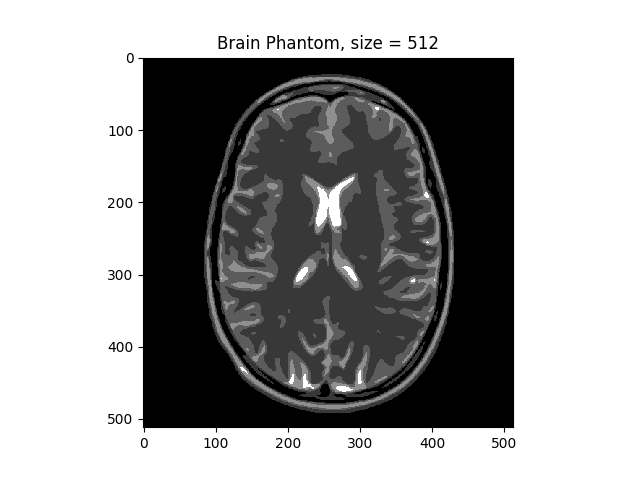

In [1]:
#DISPLAY BRAIN PHANTOM
%matplotlib nbagg

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from skimage import data, io, filters
#get current working dir
cwd = os.getcwd()
#cwd= "/"
dirimg_2d = op.join(cwd, "..", "data")
img_size = 512   #256
FOV = 0.2 #field of view in meters
pixelSize = FOV/img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom" + str(img_size) + ".png"
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename, as_gray=True)
plt.figure()
plt.title("Brain Phantom, size = "+ str(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

<IPython.core.display.Javascript object>


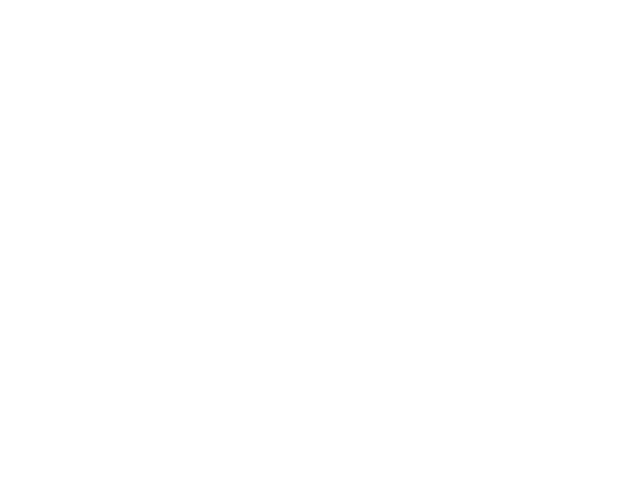

<IPython.core.display.Javascript object>


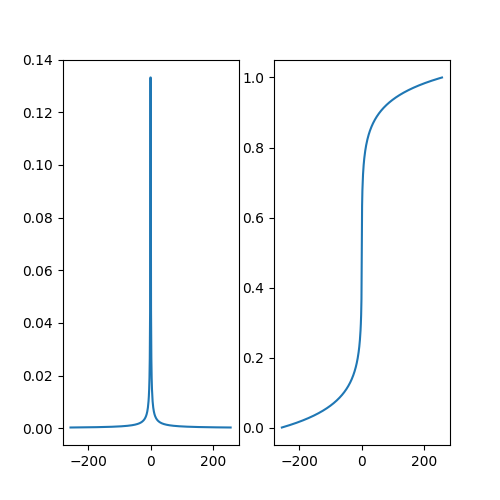

64
[255 255 255 253 257 256 268 246 291 269 255 259 247 228 132 255 251 262
 244 255 272 255  80 254 259 255 341 114 246  66 255 255 255 379 273  70
 243 249 255 319 255 276 255 274 256 255 156 216 255 255 255 307 255 231
 217 254 255 255 247 250 253 254 254 402]


<IPython.core.display.Javascript object>


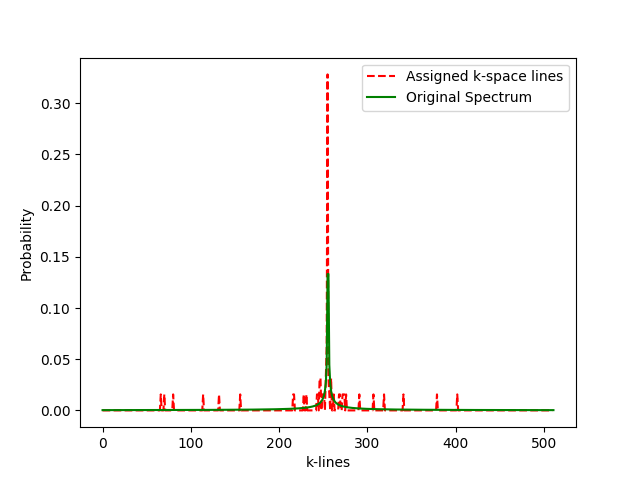

[ 66  70  80 114 132 156 216 217 228 231 243 244 246 247 249 250 251 253
 254 255 256 257 259 262 268 269 272 273 274 276 291 307 319 341 379 402]
36


<IPython.core.display.Javascript object>


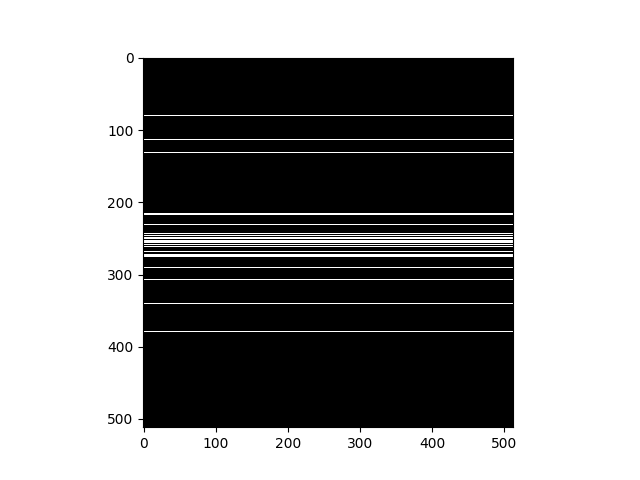

In [12]:
import numpy as np
import sys
import numpy.random as ra

eps = sys.float_info.epsilon
#img_size = 512
# generate Cartesian lines in a straightforward manner
#a = np.linspace(0,img_size,img_size)
a = (np.linspace(0,img_size,img_size+1))/img_size -0.5    # work in normalized frequency
 

c = np.ones((1, img_size), dtype="float64")
kspace_mask = np.tile(c, (img_size, 1))
#kspace_lines = np.linspace(-1/2., 1/2.,img_size)
kspace_lines = np.linspace(-1/2., 1/2.,img_size)*img_size
# define the taret sampling density (ie non-iniform over k-space lines)
decay = 1.
# Define the sampling density
p_decay = np.power(np.abs(kspace_lines),-decay)
p_decay = p_decay/np.sum(p_decay)
# generate its CDF
cdf_pdecay = np.cumsum(p_decay)


pmax = p_decay.max()
pmin = p_decay.min()

# Plot the density and its cumulative distribution function (CDF) p_decay
plt.figure()
fig, axs = plt.subplots(1, 2, figsize= (5,5) )
axs[0].plot(kspace_lines, p_decay)
axs[1].plot(kspace_lines, cdf_pdecay)

# Perform pseudo-random sampling: technique used:
# draw uniform variables and invert the CDF to get back to p_decay-distributed sampled
nb_samples = (int)(img_size/8)
print(nb_samples)
samples = ra.uniform(0, 1, nb_samples)
gen_klines = [int(kspace_lines[np.argwhere(cdf_pdecay == min(cdf_pdecay[(cdf_pdecay - r) > 0]))]) for r in samples]

# shift the samples lines by half of the k-space (ie image size as we're in Cartesian ref)
gen_klinesb = ((np.array(gen_klines) - 1) / 1).astype(int) + (int)(img_size/2)
#gen_klinesb = ((np.array(gen_klines) - 1) / 1).astype(int)
print(gen_klinesb)   # unsorted samples
times = np.arange(1, img_size, 1)
lc = np.bincount(gen_klinesb, minlength=len(times))

# check that histogram of sample values fits the prescribed density p_decay
plt.figure()
plot1, = plt.plot(lc/float(sum(lc)), 'r--', label='Assigned k-space lines')
plot2, = plt.plot(p_decay,'g',label='Original Spectrum')
plt.xlabel('k-lines')
plt.ylabel('Probability')
plt.legend(handles=[plot1,plot2])
plt.show()


#print(p_decay.min())
sampled_klines = np.array(np.unique(gen_klinesb))
print(sampled_klines)

nblines = np.size(sampled_klines)
print(nblines)
threshold = 2. * p_decay.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size,img_size), dtype="float64")
kspace_mask[sampled_klines,:] = np.ones((nblines,img_size) , dtype="float64")

plt.figure()
plt.imshow(kspace_mask, cmap='gray')
plt.show()


<IPython.core.display.Javascript object>


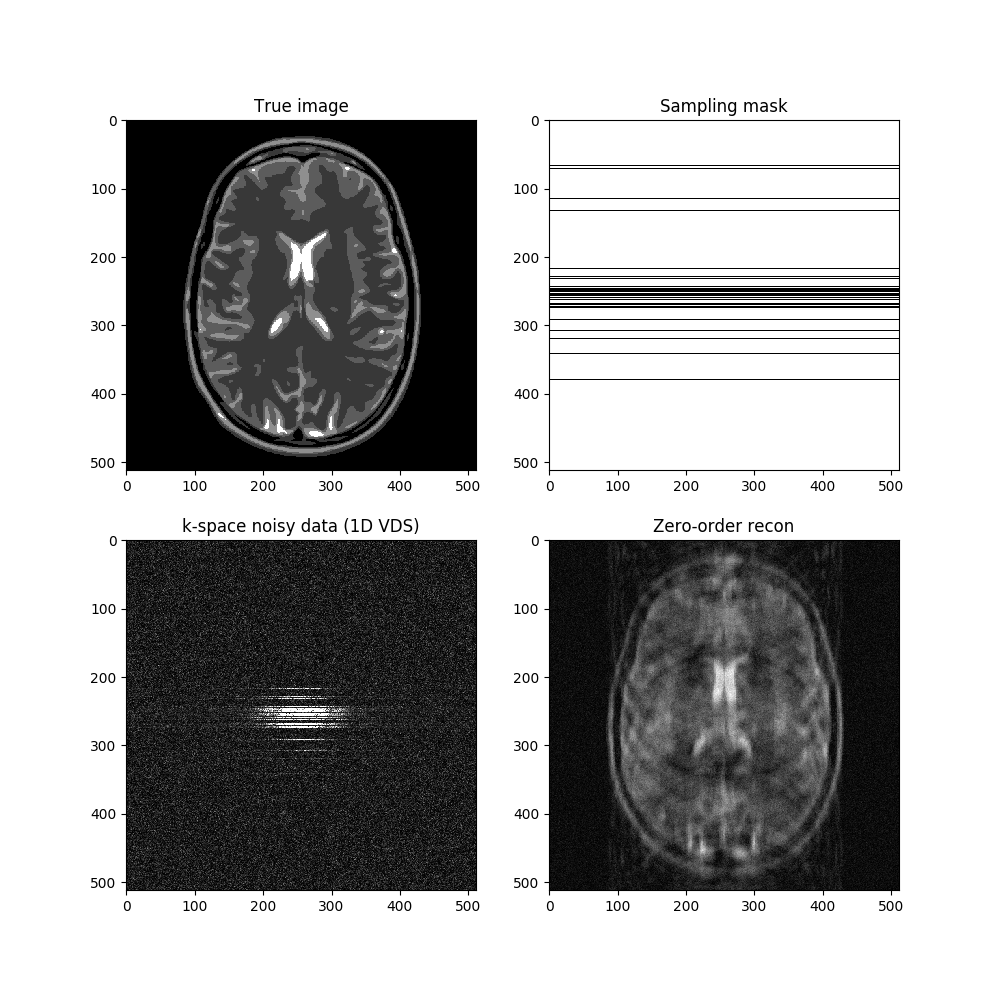

In [14]:
#import numpy.fft as fft
norm = "ortho"
#norm = None
def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

# Generate the subsampled kspace according to the sampled lines
kspace_data = np.fft.fftshift(fft(mri_img)) * kspace_mask   # put the 0-freq in the middle of axes as

#noisy k-space data using Gaussian complex-valued random noise
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='gray')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask, cmap='gray_r')
axs[0,1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.005*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data (1D VDS)")
axs[1,1].imshow(np.abs(image_rec0), cmap='gray')
axs[1,1].set_title("Zero-order recon")
plt.show()
